# Waymo Start
ref: https://colab.research.google.com/github/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb#scrollTo=sLIUOJzSyjj6

In [1]:
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od

Cloning into 'waymo-od'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 860 (delta 0), reused 1 (delta 0), pack-reused 843
Receiving objects: 100% (860/860), 14.18 MiB | 0 bytes/s, done.
Resolving deltas: 100% (550/550), done.
Checking out files: 100% (149/149), done.


In [2]:
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master

* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b new_branch_name

HEAD is now at 016a54e... Merged commit includes the following changes: 312736160  by Waymo Research:


In [3]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0 --user

     |████████████████████████████████| 2.8MB 11.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/0a/93/c7bca39b23aae45cd2e85ad3871c81eccc63b9c5276e926511e2e5b0879d/tensorflow_gpu-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/63/a5/e6c07b08b934831ccb8c98ee335e66b7761c5754ee3cabfe4c11d0b1af28/opt_einsum-3.2.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/41/bbf49b61370e4f4d245d4c6051dfb6db

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

# Read one frame
Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [9]:
FILENAME = './waymo-od/tutorial/frames'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [10]:
(range_images, camera_projections, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

In [11]:
print(frame.context)#Refer to dataset.proto for the data format. The context contains shared information among all frames in the scene.

name: "11004685739714500220_2300_000_2320_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.556149361639
  intrinsic: 2055.556149361639
  intrinsic: 939.6574698861468
  intrinsic: 641.0721821943271
  intrinsic: 0.03231600849798887
  intrinsic: -0.3214124825527059
  intrinsic: 0.0007932583953709973
  intrinsic: -0.0006257493541333847
  intrinsic: 0.0
  extrinsic {
    transform: 0.9998926849887427
    transform: -0.005993208400016058
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.006042236521329663
    transform: 0.9999751560547995
    transform: -0.003630241176497072
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.003710623431877962
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intrins

Visualize Camera Images and Camera Labels

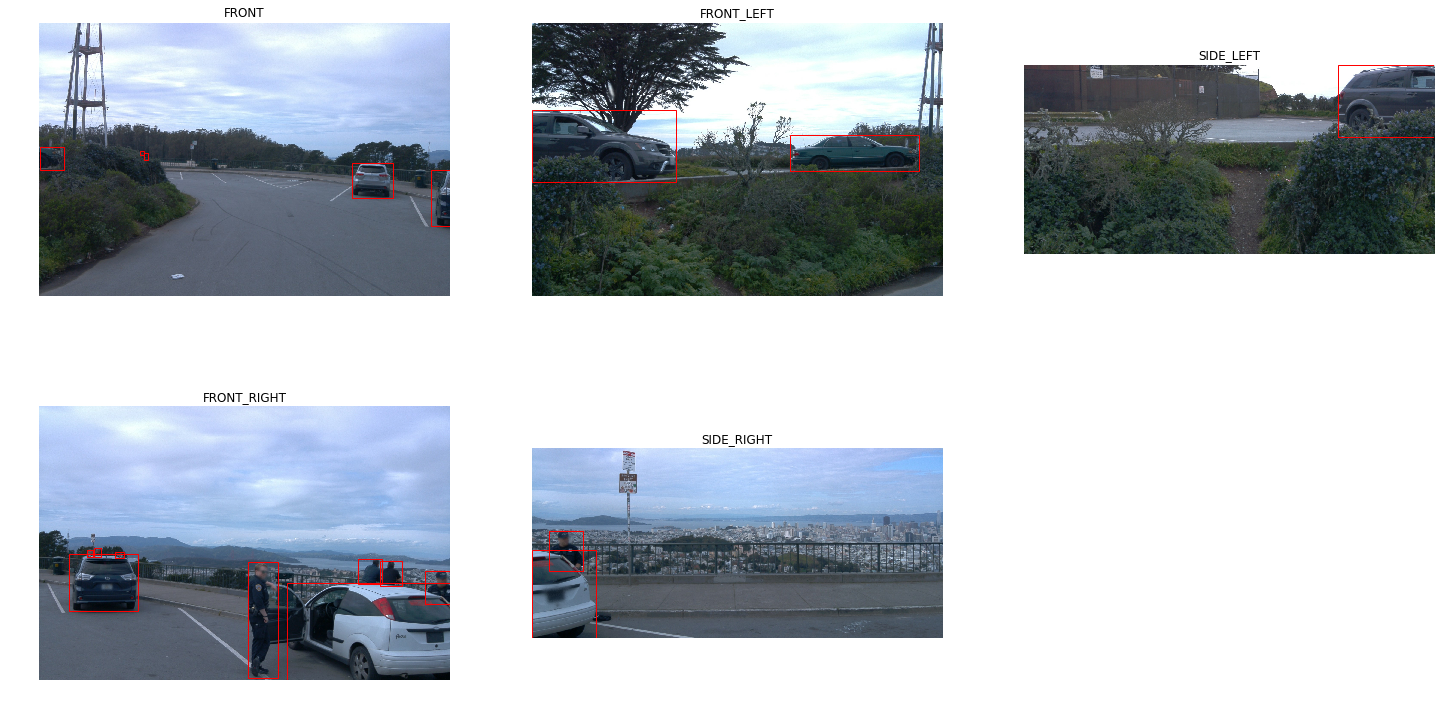

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
    """Show a camera image and the given camera labels."""

    ax = plt.subplot(*layout)

    # Draw the camera labels.
    for camera_labels in frame.camera_labels:
        #print(camera_labels)
        # Ignore camera labels that do not correspond to this camera.
        if camera_labels.name != camera_image.name:
            continue

        # Iterate over the individual labels.
        for label in camera_labels.labels:
            #print(label)
            # Draw the object bounding box.
            ax.add_patch(patches.Rectangle(
                xy=(label.box.center_x - 0.5 * label.box.length,
                    label.box.center_y - 0.5 * label.box.width),
                width=label.box.length,
                height=label.box.width,
                linewidth=1,
                edgecolor='red',
                facecolor='none'))

    # Show the camera image.
    plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
    plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
    plt.grid(False)
    plt.axis('off')


plt.figure(figsize=(25, 20))
for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

# Visualize Range Images

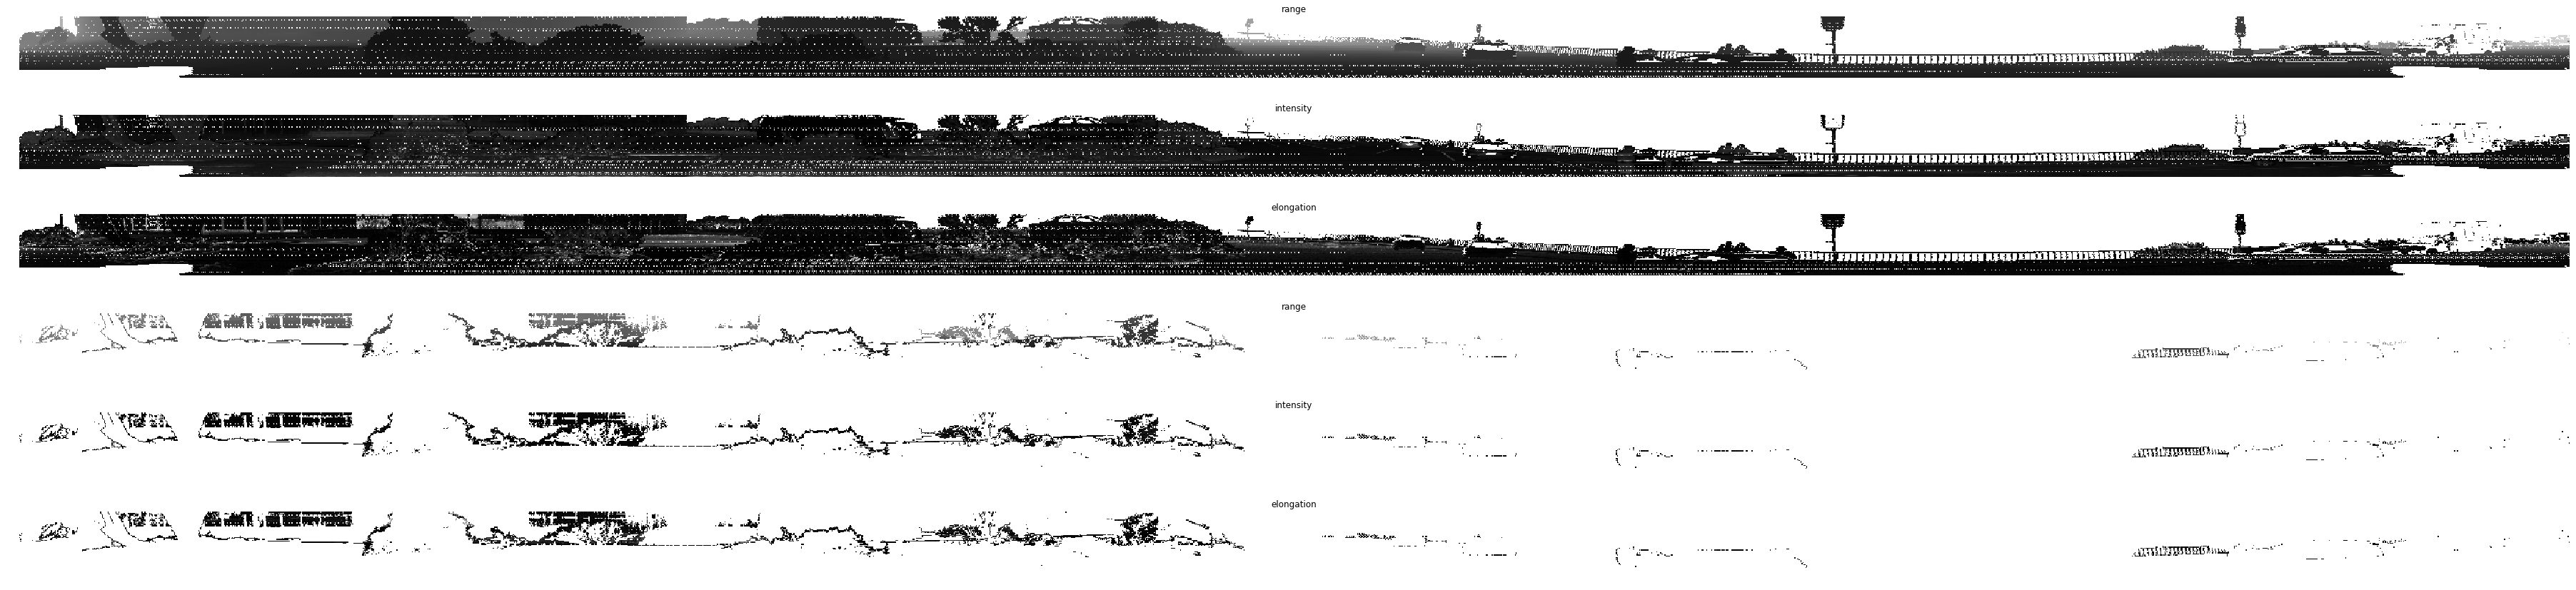

In [19]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
    """Plots range image.

    Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
    """
    plt.subplot(*layout)
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(name)
    plt.grid(False)
    plt.axis('off')

def get_range_image(laser_name, return_index):
    """Returns range image given a laser name and its return index."""
    return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
    """Shows range image.

    Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
    """
    range_image_tensor = tf.convert_to_tensor(range_image.data)
    range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
    lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
    range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
    range_image_range = range_image_tensor[...,0] 
    range_image_intensity = range_image_tensor[...,1]
    range_image_elongation = range_image_tensor[...,2]
    plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
    plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
    plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
    
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

# Point Cloud Conversion and Visualization

In [20]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

In [21]:
#Examine number of points in each lidar sensor.
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
    print(points[i].shape)
    print(cp_points[i].shape)

(126059, 3)
(126059, 6)
[[-51.13867     5.0996094   4.328842 ]
 [-51.3291      5.2441406   4.3369293]]
(108996, 3)
(108996, 6)
(3819, 3)
(3819, 6)
(4918, 3)
(4918, 6)
(3850, 3)
(3850, 6)
(4476, 3)
(4476, 6)


In [22]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
    print(points_ri2[i].shape)
    print(cp_points_ri2[i].shape)

(10104, 3)
(10104, 6)
[[-31.75293     6.5751953   3.5490723]
 [-15.777344    4.0703125   2.8928528]]
(9868, 3)
(9868, 6)
(53, 3)
(53, 6)
(125, 3)
(125, 6)
(9, 3)
(9, 6)
(49, 3)
(49, 6)


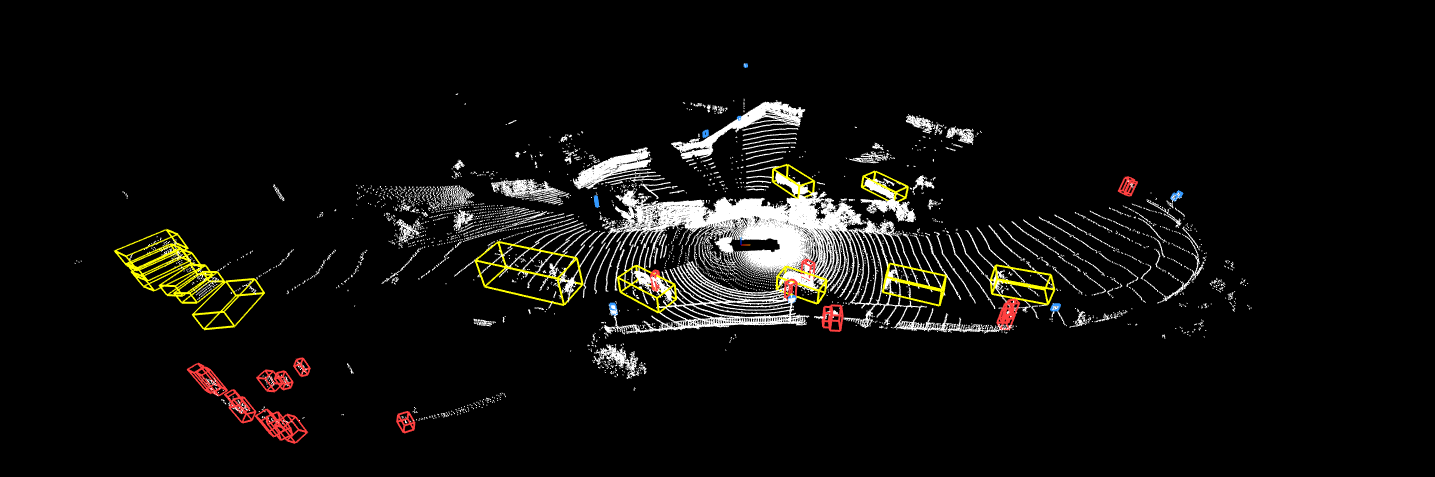

In [24]:
#Show point cloud
from IPython.display import Image, display
display(Image('./waymo-od/tutorial/3d_point_cloud.png'))

# Visualize Camera Projection

In [25]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [26]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

/opt/ohpc/pub/apps/python3/3.6.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


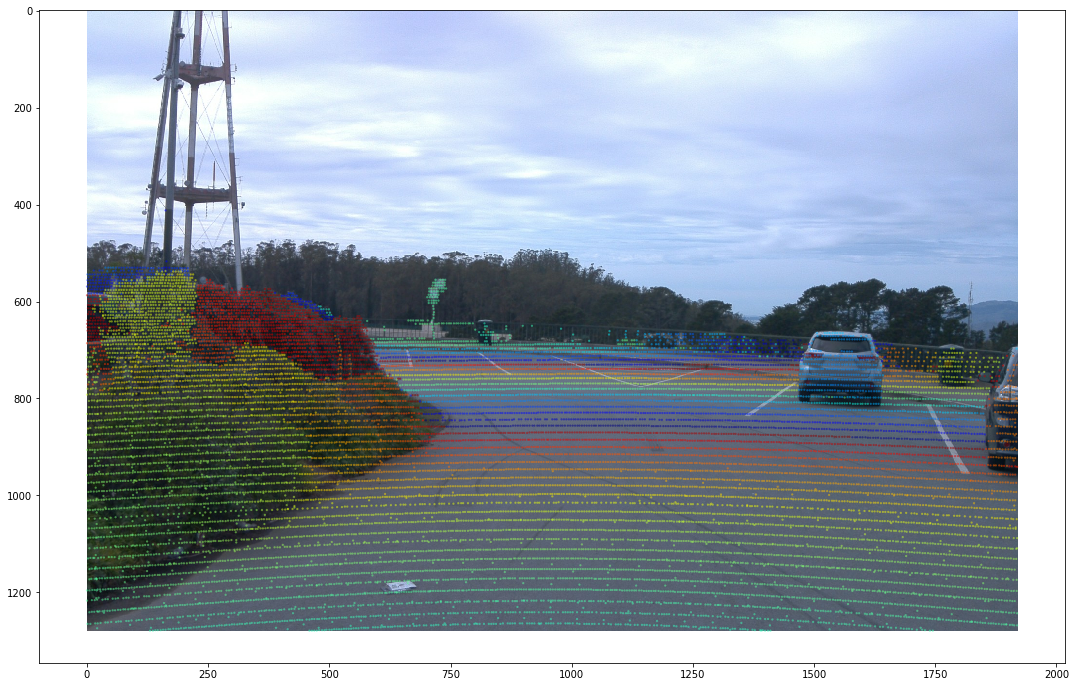

In [27]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)